# Effectuer une prédiction de revenus

Vous êtes employé dans une banque, présente dans de nombreux pays à travers le monde. Celle-ci souhaite cibler de nouveaux clients potentiels, plus particulièrement les jeunes en âge d'ouvrir leur tout premier compte bancaire.  
Cependant, elle souhaite _cibler les prospects les plus susceptibles d'avoir, plus tard dans leur vie, de hauts revenus_.  
L'équipe dans laquelle vous travaillez a donc reçu pour mission de créer un modèle permettant de déterminer le revenu potentiel d'une personne.  
Très bien.  
"Quelles informations avons-nous ?" demandez-vous à votre supérieur, qui vous répond : "À vrai dire... quasiment aucune : uniquement le revenu des parents, car nous allons cibler les enfants de nos clients actuels, ainsi que le pays où ils habitent. C'est tout ! Ah oui, une dernière chose : ce modèle doit être valable pour la plupart des pays du monde. Je vous laisse méditer là-dessus… Bon courage !"  
Avec aussi peu de données disponibles, cela semble être un sacré challenge !  
Ainsi, vous proposez une régression linéaire avec 3 variables :  
* le revenu des parents ;
* le revenu moyen du pays dans lequel habite le prospect ;
* l'indice de Gini calculé sur les revenus des habitants du pays en question.

______________________

## Importation des modules

In [1]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn import preprocessing

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as st
from collections import Counter
from scipy.stats import ks_2samp

import statsmodels.api as sm
import statsmodels.formula.api as smf
import pingouin as pg

## Chargement des données

In [2]:
data = pd.read_csv("/Users/anissa/P7/data-projet7.csv", decimal=',')
population = pd.read_csv("/Users/anissa/P7/API_SP/population.csv", skiprows=4)
gini = pd.read_csv("/Users/anissa/P7/gini.csv", skiprows=4, sep=',')
coeff_elasticite = pd.read_csv("/Users/anissa/P7/coeff_elasticite.csv")

_______________

## Exploration des données et nettoyage

In [3]:
print('Valeurs manquantes :\n' + str(data.isnull().sum()))
# 200 valeurs manquantes

Valeurs manquantes :
country           0
year_survey       0
quantile          0
nb_quantiles      0
income            0
gdpppp          200
dtype: int64


In [4]:
print('Valeurs dupliquées : ', data.duplicated().sum())

Valeurs dupliquées :  0


### 1. Valeurs manquantes

#### 1.1. GDPPPP manquants

In [5]:
# Recherche des valeurs manquantes
lignes_nulles = data[data.isnull().any(axis=1)]
lignes_nulles.head() #gdpppp manquants

,country,year_survey,quantile,nb_quantiles,income,gdpppp
5800,XKX,2008,1,100,437.89370,NaN
5801,XKX,2008,2,100,508.17133,NaN
5802,XKX,2008,3,100,591.82820,NaN
5803,XKX,2008,4,100,668.00000,NaN
5804,XKX,2008,5,100,730.40220,NaN


In [6]:
# Localisation des pays où le gdpppp est manquant
lignes_nulles.country.unique()

array(['XKX', 'PSE'], dtype=object)

In [7]:
# Affectation des valeurs pour les valeurs manquantes
data.loc[data['country'] == 'XKX', 'gdpppp'] = 3254.9
data.loc[data['country'] == 'PSE', 'gdpppp'] = 2035

#### 1.2. Quantile manquant

In [8]:
# Vérification du nombre de quantiles par pays
pays_nb_quantiles = data[['country', 'quantile']].groupby('country').count()
pays_nb_quantiles.head()

,quantile
country,
ALB,100
ARG,100
ARM,100
AUT,100
AZE,100


In [9]:
# On vérifie si tous les pays comptent bien 100 quantiles
pays_nb_quantiles[pays_nb_quantiles['quantile'] != 100] # il manque 1 quantile pour la Lituanie

,quantile
country,
LTU,99


In [10]:
for i in range(1,101):
    if i not in data.loc[data['country'] == 'LTU','quantile'].values:
        print("Le quantile",i,"n'est pas présent.")

Le quantile 41 n'est pas présent.


In [11]:
# On localise les données situées avant et après le quantile manquant
data.loc[(data['country'] == 'LTU') & (data['quantile'].isin([40,42]))]

,country,year_survey,quantile,nb_quantiles,income,gdpppp
6239,LTU,2008,40,100,4868.4507,17571.0
6240,LTU,2008,42,100,4895.8306,17571.0


In [12]:
# Ajout des données dans une nouvelles lignes du df
data.loc['6239a'] = ['LTU', 2008, 41, 100, ((4868.4507 + 4895.8306) / 2), 17571.0]
data.head()

,country,year_survey,quantile,nb_quantiles,income,gdpppp
0,ALB,2008,1,100,728.89795,7297.0
1,ALB,2008,2,100,916.66235,7297.0
2,ALB,2008,3,100,1010.91600,7297.0
3,ALB,2008,4,100,1086.90780,7297.0
4,ALB,2008,5,100,1132.69970,7297.0


#### 1.4. Valeur aberrante

In [13]:
# Traitement des données aberrantes pour les Fidji
data.replace(["4300332"], "7777,6")

,country,year_survey,quantile,nb_quantiles,income,gdpppp
0,ALB,2008,1,100,728.89795,7297.00000
1,ALB,2008,2,100,916.66235,7297.00000
2,ALB,2008,3,100,1010.91600,7297.00000
3,ALB,2008,4,100,1086.90780,7297.00000
4,ALB,2008,5,100,1132.69970,7297.00000
...,...,...,...,...,...,...
11595,COD,2008,97,100,911.78340,303.19305
11596,COD,2008,98,100,1057.80740,303.19305
11597,COD,2008,99,100,1286.60290,303.19305
11598,COD,2008,100,100,2243.12260,303.19305


### 2. Résumé des données utilisées

#### 2.1. Années utilisées

In [14]:
year = data['year_survey'].unique()
print(np.sort(year))

[2004 2006 2007 2008 2009 2010 2011]


#### 2.2. Nombre de pays présents

In [15]:
country = data['country'].unique()
print('Nombre de pays présents dans l\'échantillon : ', len(country))

Nombre de pays présents dans l'échantillon :  116


#### 2.3. Population couverte par l'analyse

In [16]:
# Restriction sur les colonnes utiles
pop = population[['Country Code', '2008', 'Country Name']]

# Merge des deux df pour obtenir le nom du pays en fonction de son code ISO
data = pd.merge(data, pop, left_on='country', right_on='Country Code')
data = data[['country', 'year_survey', 'quantile', 'nb_quantiles', 
             'income', 'gdpppp', "2008", "Country Name"]]
data = data.rename(columns={"2008":'population', "Country Code":"ISO", 
                            "Country Name":"pays"})
data.head()

,country,year_survey,quantile,nb_quantiles,income,gdpppp,population,pays
0,ALB,2008,1,100,728.89795,7297.0,2947314.0,Albanie
1,ALB,2008,2,100,916.66235,7297.0,2947314.0,Albanie
2,ALB,2008,3,100,1010.91600,7297.0,2947314.0,Albanie
3,ALB,2008,4,100,1086.90780,7297.0,2947314.0,Albanie
4,ALB,2008,5,100,1132.69970,7297.0,2947314.0,Albanie


In [17]:
# Vérification des valeurs manquantes
data.isnull().sum()

country         0
year_survey     0
quantile        0
nb_quantiles    0
income          0
gdpppp          0
population      0
pays            0
dtype: int64

In [18]:
# On sélectionne la ligne qui nous intéresse
popu = population.loc[population["Country Name"]=="Monde"]
international = popu["2008"].values[0]

# Calcul de la population couverte par l'étude
inter = data.groupby(by='country').mean()
pop_couverte = inter['population'].sum()

pourcent_pop_etude = 100 * pop_couverte / international
print('Population couverte par l\'analyse : ' + str(pourcent_pop_etude) + '%.')

Population couverte par l'analyse : 91.47293572868858%.


In [19]:
# On crée une copie de notre df
donnees_monde = data.copy()
donnees_monde.head()

,country,year_survey,quantile,nb_quantiles,income,gdpppp,population,pays
0,ALB,2008,1,100,728.89795,7297.0,2947314.0,Albanie
1,ALB,2008,2,100,916.66235,7297.0,2947314.0,Albanie
2,ALB,2008,3,100,1010.91600,7297.0,2947314.0,Albanie
3,ALB,2008,4,100,1086.90780,7297.0,2947314.0,Albanie
4,ALB,2008,5,100,1132.69970,7297.0,2947314.0,Albanie


NB :
   * Le type de quantiles utilisé pour la variable "income" est le **centile/percentile**.  
   * Cela permet de _réduire la taille de l’échantillon_ tout en préservant suffisamment d’informations + _gommer les écarts entre les pays_

______________________

### 3. Analyse des données

#### 3.1. Diversité des pays en termes de distribution de revenus

##### 3.1.1. Sélection de pays représentatifs

1 : 64622749.89948084
2 : 32931792.952655643
3 : 20051278.576419074
4 : 12484055.857360132
5 : 10670813.39068916
6 : 9592680.91212997
7 : 7234785.087579055
8 : 6268839.773234789
9 : 4866049.660379379


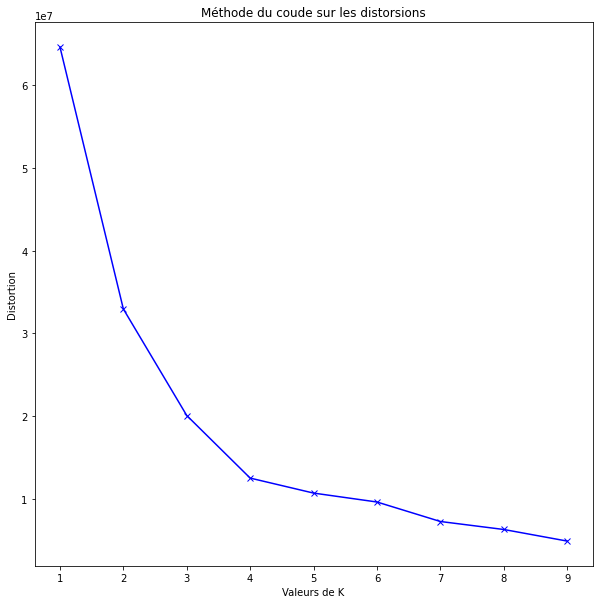

In [20]:
X = data[['gdpppp', 'population']].values

distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(X) 
    kmeanModel.fit(X)     
      
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / X.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / X.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 


for key,val in mapping1.items(): 
    print(str(key)+' : '+str(val)) 

plt.figure(figsize=(10,10))
sns.set_palette("rocket")
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Valeurs de K') 
plt.ylabel('Distortion') 
plt.title('Méthode du coude sur les distorsions') 

plt.show()

In [21]:
nb_cluster = 4
X = data.gdpppp.values.reshape(-1, 1)
X = data[['gdpppp', 'population']].values.reshape(-1, 1)

# Normalisation des données
pays_info_norm = preprocessing.scale(X)
# Clustering avec la méthode des kmeans
km = KMeans(n_clusters = nb_cluster).fit(X)
# On determine les pays qui sont les plus proches des centroïdes des clusters
i_pays_plus_proches, _ = pairwise_distances_argmin_min(km.cluster_centers_, X)
pays_representatifs_cluster = data.iloc[i_pays_plus_proches].sort_values('gdpppp', ascending=False)
pays_representatifs_cluster

,country,year_survey,quantile,nb_quantiles,income,gdpppp,population,pays
3401,GBR,2008,2,100,3946.32180,34048.00000,61806995.0,Royaume-Uni
2401,DEU,2008,2,100,4179.01460,33758.00000,82110097.0,Allemagne
10001,THA,2006,2,100,351.28305,7469.00000,66530984.0,Thaïlande
7001,MLI,2010,2,100,178.90753,929.52966,14113577.0,Mali


##### 3.1.3. Revenus moyens des pays sélectionnés

In [22]:
pays_panel = ['France', 'Royaume-Uni', 'Allemagne', 'Thaïlande', 'Mali']
panel = data[data['pays'].isin(pays_panel)]
panel.head()

,country,year_survey,quantile,nb_quantiles,income,gdpppp,population,pays
2400,DEU,2008,1,100,2205.0122,33758.0,82110097.0,Allemagne
2401,DEU,2008,2,100,4179.0146,33758.0,82110097.0,Allemagne
2402,DEU,2008,3,100,5065.8580,33758.0,82110097.0,Allemagne
2403,DEU,2008,4,100,5707.7173,33758.0,82110097.0,Allemagne
2404,DEU,2008,5,100,6236.1500,33758.0,82110097.0,Allemagne


***Revenus moyens à l'échelle logarithmique***

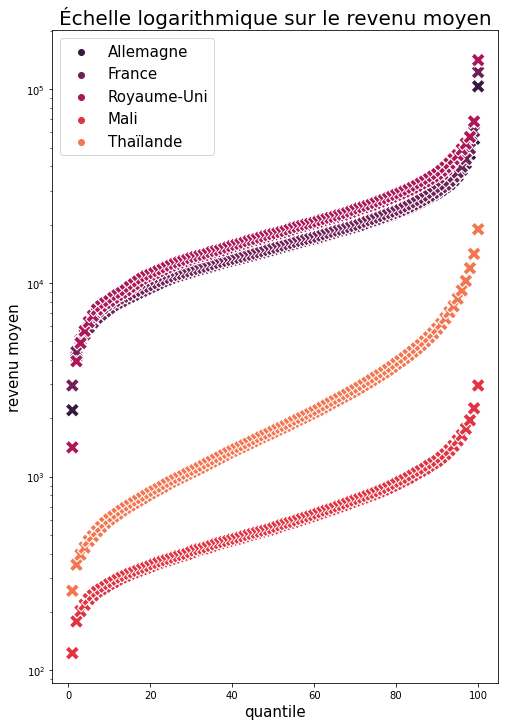

In [23]:
plt.figure(figsize=(8, 12))

ax = sns.scatterplot(
    data=panel, x='quantile', y='income', 
    hue='pays', marker='X', s=200)
ax.set(yscale="log")

plt.title('Échelle logarithmique sur le revenu moyen', size=20)
plt.ylabel("revenu moyen", size=15)
plt.xlabel("quantile", size=15)
plt.legend(prop={"size":15})

plt.savefig("/Users/anissa/01_Echelle logarithme sur le revenu moyen.jpg", dpi=1200)

plt.show()

***Revenus moyens par pays***

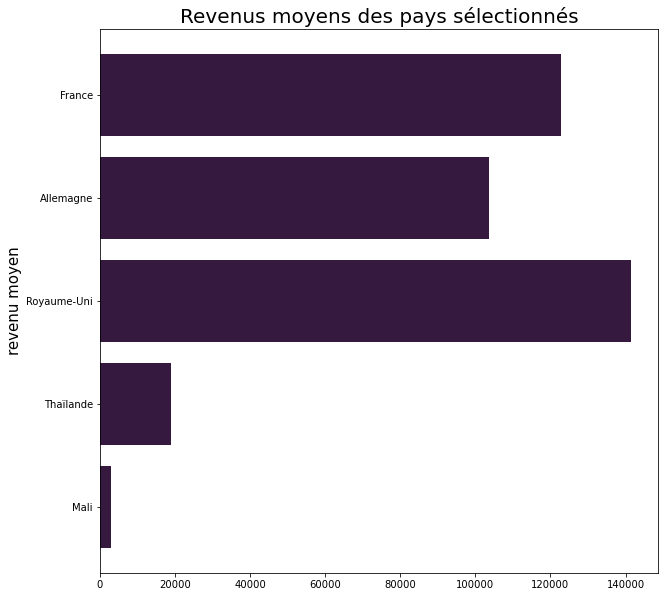

In [24]:
incomes_pays = data[(data['pays'] == 'France') |
                     (data['pays'] == 'Mali') |
                     (data['pays'] == 'Thaïlande') |
                     (data['pays'] == 'Allemagne') |
                     (data['pays'] == 'Royaume-Uni')].sort_values('income')

plt.figure(figsize=(10,10))

plt.barh(incomes_pays.pays, incomes_pays.income)

plt.title('Revenus moyens des pays sélectionnés', size=20)
plt.ylabel("revenu moyen", size=15)

plt.savefig("/Users/anissa/02_Diagramme bâton revenus moyens.jpg", dpi=1200)

plt.show()

#### 3.2. Courbes de lorenz pour chacun des pays choisis

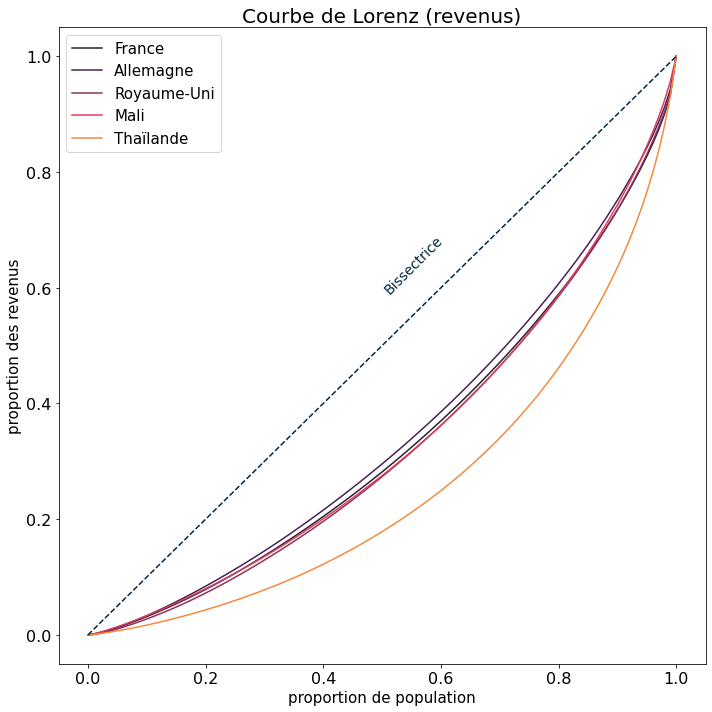

In [25]:
income_fra = data[data['pays'] == 'France']
income_all = data[data['pays'] == 'Allemagne']
income_uk = data[data['pays'] == 'Royaume-Uni']
income_mal = data[data['pays'] == 'Mali']
income_thai = data[data['pays'] == 'Thaïlande']

incomes_fra = income_fra['income'].values
lorenz_fra = np.cumsum(np.sort(incomes_fra)) / incomes_fra.sum()
lorenz_fra = np.append([0], lorenz_fra)

incomes_all = income_all['income'].values
lorenz_all = np.cumsum(np.sort(incomes_all)) / incomes_all.sum()
lorenz_all = np.append([0], lorenz_all)

incomes_uk = income_uk['income'].values
lorenz_uk = np.cumsum(np.sort(incomes_uk)) / incomes_uk.sum()
lorenz_uk = np.append([0], lorenz_uk)

incomes_mal = income_mal['income'].values
lorenz_mal = np.cumsum(np.sort(incomes_mal)) / incomes_mal.sum()
lorenz_mal = np.append([0], lorenz_mal)

incomes_thai = income_thai['income'].values
lorenz_thai = np.cumsum(np.sort(incomes_thai)) / incomes_thai.sum()
lorenz_thai = np.append([0], lorenz_thai)

plt.figure(figsize=(10,10))

plt.plot(np.linspace(0,1,len(lorenz_fra)),lorenz_fra, color='#2A1D2F')
plt.plot(np.linspace(0,1,len(lorenz_all)),lorenz_all, color='#461F55')
plt.plot(np.linspace(0,1,len(lorenz_uk)),lorenz_uk, color='#902F5B')
plt.plot(np.linspace(0,1,len(lorenz_mal)),lorenz_mal, color='#DD3D59')
plt.plot(np.linspace(0,1,len(lorenz_thai)),lorenz_thai, color='#F58A3E')

x = [0, 1]
y = [0, 1]
plt.plot(x, y, '#002740', linestyle='--', label='Médiatrice')
plt.text(0.5, 0.59, 'Bissectrice', fontsize=14, rotation = 45, color ='#002740')

label = ['France',  'Allemagne', 'Royaume-Uni', 'Mali', 'Thaïlande']

plt.title('Courbe de Lorenz (revenus)', fontsize=20)
plt.ylabel('proportion des revenus', fontsize=15)
plt.yticks(fontsize=16)
plt.xlabel('proportion de population', fontsize=15)
plt.xticks(fontsize=16)
plt.legend(label, prop={'size':15})
plt.tight_layout()

plt.savefig("/Users/anissa/03_Courbe de Lorenz.jpg", dpi=1200)

plt.show()

#### 3.3. Evolution de l'indice de Gini au fil des ans

In [26]:
# Sélection des pays retenus pour la démonstration
gini_index = gini.set_index('Country Code')
gini_index = gini_index.loc(axis=0)['FRA', 'GBR','DEU', 'THA', 'MLI']

# Sélection des indices de Gini pour les années de notre échantillon
gini_index = gini_index[['2004', '2006', '2007', '2008', '2009', '2010','2011']]
gini_index

,2004,2006,2007,2008,2009,2010,2011
Country Code,,,,,,,
FRA,30.6,29.7,32.4,33.0,32.7,33.7,33.3
GBR,36.0,34.6,35.7,34.1,34.3,34.4,33.2
DEU,30.4,31.3,31.3,31.1,30.5,30.2,30.5
THA,42.5,41.8,39.8,40.3,39.6,39.4,37.5
MLI,NaN,38.9,NaN,NaN,33.0,NaN,NaN


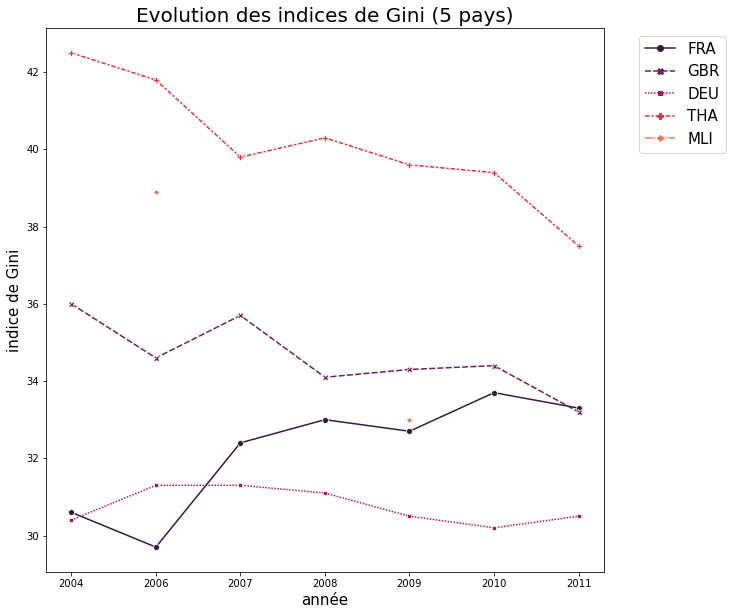

In [27]:
# Représentation graphique des indices de Gini pour nos différents pays
gini_T = gini_index.T


plt.figure(figsize=(10,10))
sns.lineplot(data=gini_T, markers=True)
plt.title('Evolution des indices de Gini (5 pays)', size=20)
plt.xlabel('année', size=15)
plt.ylabel('indice de Gini', size=15)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', prop={"size":15})

plt.savefig("/Users/anissa/04_Evolution des indices de Gini.jpg", dpi=1200)

plt.show()

#### 3.4. Classement des indices Gini

***Moyenne des indices de Gini***

In [28]:
gini_classement = gini[['Country Name', '2008']]
print('Moyenne des indices de Gini :',
      (round(gini_classement['2008']).mean()/100))

Moyenne des indices de Gini : 0.3756164383561644


##### 3.4.1. 5 pays ayant l'indice de Gini le plus élevé

In [29]:
gini_classement.sort_values(by='2008', ascending=False).head(5)

,Country Name,2008
261,South Africa,63.0
32,Central African Republic,56.2
95,Honduras,55.5
43,Colombia,55.3
27,Brazil,54.0


##### 3.4.2. 5 pays ayant l'indice de Gini le plus faible

In [30]:
gini_classement.sort_values(by='2008', ascending=True).head(5)

,Country Name,2008
220,Slovenia,23.7
56,Denmark,25.2
219,Slovak Republic,26.0
52,Czech Republic,26.3
246,Ukraine,26.6


***Position de la France dans le classement des indices de Gini***

In [31]:
position_france = gini_classement[gini_classement['Country Name']=='France']
print('France :\n', 
        position_france.index[0], 'ème pays le plus égalitaire\n',
        len(gini_classement) + 1 - position_france.index[0], 
        'ème pays le plus inégalitaire\nIndice de Gini :',
        round(float(position_france['2008']/100), 2), '\n')

France :
 75 ème pays le plus égalitaire
 190 ème pays le plus inégalitaire
Indice de Gini : 0.33 



__________________

### 4. Génération de la classe parent

In [32]:
gini_index = gini_index.reset_index()
gini_index = gini_index[['Country Code','2004', '2006', '2007', '2008', 
                         '2009', '2010','2011']]
data = pd.merge(donnees_monde, gini, left_on = 'country', right_on='Country Code')
data = data[['Country Code', 'country', 'year_survey', 'quantile', 
             'nb_quantiles','income', 'gdpppp',  '2008', 'population']]
data = data.rename(columns={'2008' : 'gini'})

# Projection sur les colonnes utiles
gdim = coeff_elasticite[['countryname', 'iso3', 'region', 'incgroup4', 
                         'year', 'IGEincome']]

# Merge entre nos différents df
data2 = pd.merge(data, gdim, left_on='country', right_on='iso3')
data2 = data2.drop(columns=['iso3', 'year_survey'])
data2 = data2.drop_duplicates()

data2.head()

,Country Code,country,quantile,nb_quantiles,income,gdpppp,gini,population,countryname,region,incgroup4,year,IGEincome
0,ALB,ALB,1,100,728.89795,7297.0,30.0,2947314.0,Albania,Europe & Central Asia,Upper middle income,1940,NaN
12,ALB,ALB,1,100,728.89795,7297.0,30.0,2947314.0,Albania,Europe & Central Asia,Upper middle income,1950,NaN
24,ALB,ALB,1,100,728.89795,7297.0,30.0,2947314.0,Albania,Europe & Central Asia,Upper middle income,1960,NaN
36,ALB,ALB,1,100,728.89795,7297.0,30.0,2947314.0,Albania,Europe & Central Asia,Upper middle income,1970,0.815874
48,ALB,ALB,1,100,728.89795,7297.0,30.0,2947314.0,Albania,Europe & Central Asia,Upper middle income,1980,NaN


#### 4.1. Protocole de génération pour un pays donné

***Environnement de travail***

In [33]:
def generate_incomes(n, pj):
    ln_y_parent = st.norm(0,1).rvs(size=n)
    residues = st.norm(0,1).rvs(size=n)
    return np.exp(pj*ln_y_parent + residues), np.exp(ln_y_parent)

def quantiles(l, nb_quantiles):
    size = len(l)
    l_sorted = l.copy()
    l_sorted = l_sorted.sort_values()
    quantiles = np.round(np.arange(1, nb_quantiles+1, nb_quantiles/size) -0.5 +1./size)
    q_dict = {a:int(b) for a,b in zip(l_sorted,quantiles)}
    return pd.Series([q_dict[e] for e in l])

def compute_quantiles(y_child, y_parents, nb_quantiles):
    y_child = pd.Series(y_child)
    y_parents = pd.Series(y_parents)
    c_i_child = quantiles(y_child, nb_quantiles)
    c_i_parent = quantiles(y_parents, nb_quantiles)
    sample = pd.concat([y_child, y_parents, c_i_child, c_i_parent], axis=1)
    sample.columns = ["y_child", "y_parents", "c_i_child","c_i_parent"]
    return sample

def distribution(counts, nb_quantiles):
    distrib = []
    total = counts["counts"].sum()
    
    if total == 0 :
        return [0] * nb_quantiles
    
    for q_p in range(1, nb_quantiles+1):
        subset = counts[counts.c_i_parent == q_p]
        if len(subset):
            nb = subset["counts"].values[0]
            distrib += [nb / total]
        else:
            distrib += [0]
    return distrib

def conditional_distributions(sample, nb_quantiles):
    counts = sample.groupby(["c_i_child","c_i_parent"]).apply(len)
    counts = counts.reset_index()
    counts.columns = ["c_i_child","c_i_parent","counts"]
    
    mat = []
    for child_quantile in np.arange(nb_quantiles)+1:
        # on recupere les indivdus ou les enfants sont dans ce quantile
        subset = counts[counts.c_i_child == child_quantile]
        mat += [distribution(subset, nb_quantiles)]
    return mat

def proba_cond(c_i_parent, c_i_child, mat):
    return mat[c_i_child][c_i_parent]

def plot_conditional_distributions(p, cd, nb_quantiles):
    plt.figure()
    
    # La ligne suivante sert à afficher un graphique en "stack bars", sur ce modèle : https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
    cumul = np.array([0] * nb_quantiles)
    
    for i, child_quantile in enumerate(cd):
        plt.bar(np.arange(nb_quantiles)+1, child_quantile, bottom=cumul, width=0.95, label = str(i+1) +"e")
        cumul = cumul + np.array(child_quantile)

    plt.axis([.5, nb_quantiles*1.3 ,0 ,1])
    plt.title("p=" + str(p))
    plt.legend()
    plt.xlabel("quantile parents")
    plt.ylabel("probabilité du quantile enfant")
    plt.show()

##### 4.1.1. Calcul de y_child

In [34]:
pj = 0.9                 # coefficient d'élasticité du pays j
nb_quantiles = 10        # nombre de quantiles (nombre de classes de revenu)
n  = 1000*nb_quantiles   # taille de l'échantillon

y_child, y_parents = generate_incomes(n, pj)

##### 4.1.2. Calcul de la classe de revenus des enfants "c_i_child" à partir de "y_child" et "y_parent"

In [35]:
sample = compute_quantiles(y_child, y_parents, nb_quantiles)
sample.head()

,y_child,y_parents,c_i_child,c_i_parent
0,2.866729,0.786657,8,5
1,1.689749,1.048232,7,6
2,0.410244,0.927945,3,5
3,2.553193,1.399120,8,7
4,6.986611,2.898505,10,9


##### 4.1.3. Distribution conditionnelle de "c_i_parent"

In [36]:
cd = conditional_distributions(sample, nb_quantiles)

##### 4.1.4. Représentation graphique des distributions conditionnelles

***Faible mobilité (pj=0.9)***

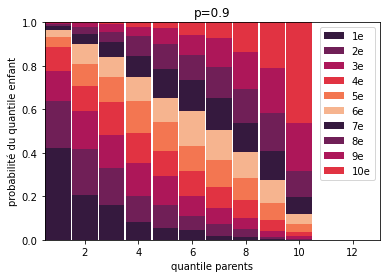

In [37]:
plot_conditional_distributions(0.9, cd, nb_quantiles)

#### 4.1. Nouvel échantillon

In [38]:
del y_parents, y_child
dist_cond = data2.copy()

# On créé 499 copies de chaques enfants
new_sample = dist_cond.append([dist_cond]*499, ignore_index=True)
new_sample['c_i_parent'] = 0

dist_cond2 = new_sample.copy()
dist_pays = dist_cond2[['country', 'quantile', 'income', 'IGEincome', 
                        'c_i_parent', 'gini']]
# Renomme
dist_pays.columns = ['country', 'c_i_child', 'income_child', 
                     'coeff_elasticite', 'c_i_parent', 'Gj'] 

distrib_pays = dist_pays.copy()
distrib_pays.head()

,country,c_i_child,income_child,coeff_elasticite,c_i_parent,Gj
0,ALB,1,728.89795,NaN,0,30.0
1,ALB,1,728.89795,NaN,0,30.0
2,ALB,1,728.89795,NaN,0,30.0
3,ALB,1,728.89795,0.815874,0,30.0
4,ALB,1,728.89795,NaN,0,30.0


##### 4.1.1. Attribution des classes des parents

In [39]:
nb_quantiles = 100       # nombre de quantiles (nombre de classes de revenu)
n  = len(distrib_pays) # taille de l'échantillon
ln_y_parent = st.norm(0,1).rvs(size=n)
residus = st.norm(0,1).rvs(size=n)

distrib_pays2 = pd.concat([
    pd.DataFrame(list(zip(ln_y_parent, residus)), columns=['ln_y_parent','residus']), 
    distrib_pays], axis=1)

def generate_y_child(n, pj):
    return np.exp(pj * ln_y_parent + residus)

def generate_y_parents(n, pj):
    return np.exp(ln_y_parent)

distrib_pays2['y_child'] = 0
distrib_pays2['y_child'] = generate_y_child(n, distrib_pays['coeff_elasticite'])
distrib_pays2['y_parents'] = 0
distrib_pays2['y_parents'] = generate_y_parents(n, distrib_pays['coeff_elasticite'])

distrib_pays2['c_i_child'] = pd.qcut(distrib_pays2['y_child'], 100, labels=False) +1
distrib_pays2['c_i_parent'] = pd.qcut(distrib_pays2['y_parents'], 100, labels=False) +1

# Suppression de la variable c_i_child inutile pour la mission 4
distrib_pays2.drop(columns='c_i_child', inplace=True)

distrib_pays2.head()

,ln_y_parent,residus,country,income_child,coeff_elasticite,c_i_parent,Gj,y_child,y_parents
0,0.566831,0.951167,ALB,728.89795,NaN,72,30.0,NaN,1.762672
1,-2.044726,0.435600,ALB,728.89795,NaN,3,30.0,NaN,0.129416
2,-0.163749,1.210706,ALB,728.89795,NaN,44,30.0,NaN,0.848955
3,0.386460,-0.091086,ALB,728.89795,0.815874,66,30.0,1.251342,1.471762
4,-0.107841,-1.312594,ALB,728.89795,NaN,46,30.0,NaN,0.897771


In [40]:
# Création d'un dataframe avec la variable revenu moyen du pays
y_child_moy_df = distrib_pays2.groupby(by='country').mean()
y_child_moy_df.reset_index(inplace=True)
y_child_moy_df = y_child_moy_df[['country', 'income_child']]
y_child_moy_df.rename(columns={'income_child': 'mj'}, inplace=True)

y_child_moy_df.head()

,country,mj
0,ALB,2994.829902
1,ARG,5847.884654
2,ARM,1628.382785
3,AUT,16637.600204
4,AZE,2357.429023


In [41]:
# Ajout de la colonne y_child_moy
bdd_p7 = pd.merge(distrib_pays2, y_child_moy_df, on='country')
# Ajout des colonnes 'logarithmes'
bdd_p7['ln_y_child'] = np.log(bdd_p7['income_child'])
bdd_p7['ln_mj'] = np.log(bdd_p7['mj'])

bdd_p7.head()

,ln_y_parent,residus,country,income_child,coeff_elasticite,c_i_parent,Gj,y_child,y_parents,mj,ln_y_child,ln_mj
0,0.566831,0.951167,ALB,728.89795,NaN,72,30.0,NaN,1.762672,2994.829902,6.591534,8.004643
1,-2.044726,0.435600,ALB,728.89795,NaN,3,30.0,NaN,0.129416,2994.829902,6.591534,8.004643
2,-0.163749,1.210706,ALB,728.89795,NaN,44,30.0,NaN,0.848955,2994.829902,6.591534,8.004643
3,0.386460,-0.091086,ALB,728.89795,0.815874,66,30.0,1.251342,1.471762,2994.829902,6.591534,8.004643
4,-0.107841,-1.312594,ALB,728.89795,NaN,46,30.0,NaN,0.897771,2994.829902,6.591534,8.004643


____________________

### 5. Explication du revenu des individus en fonction de plusieurs variables

#### 5.1. Représentation graphique des revenus des pays

***Boxplots pour les pays représentatifs***

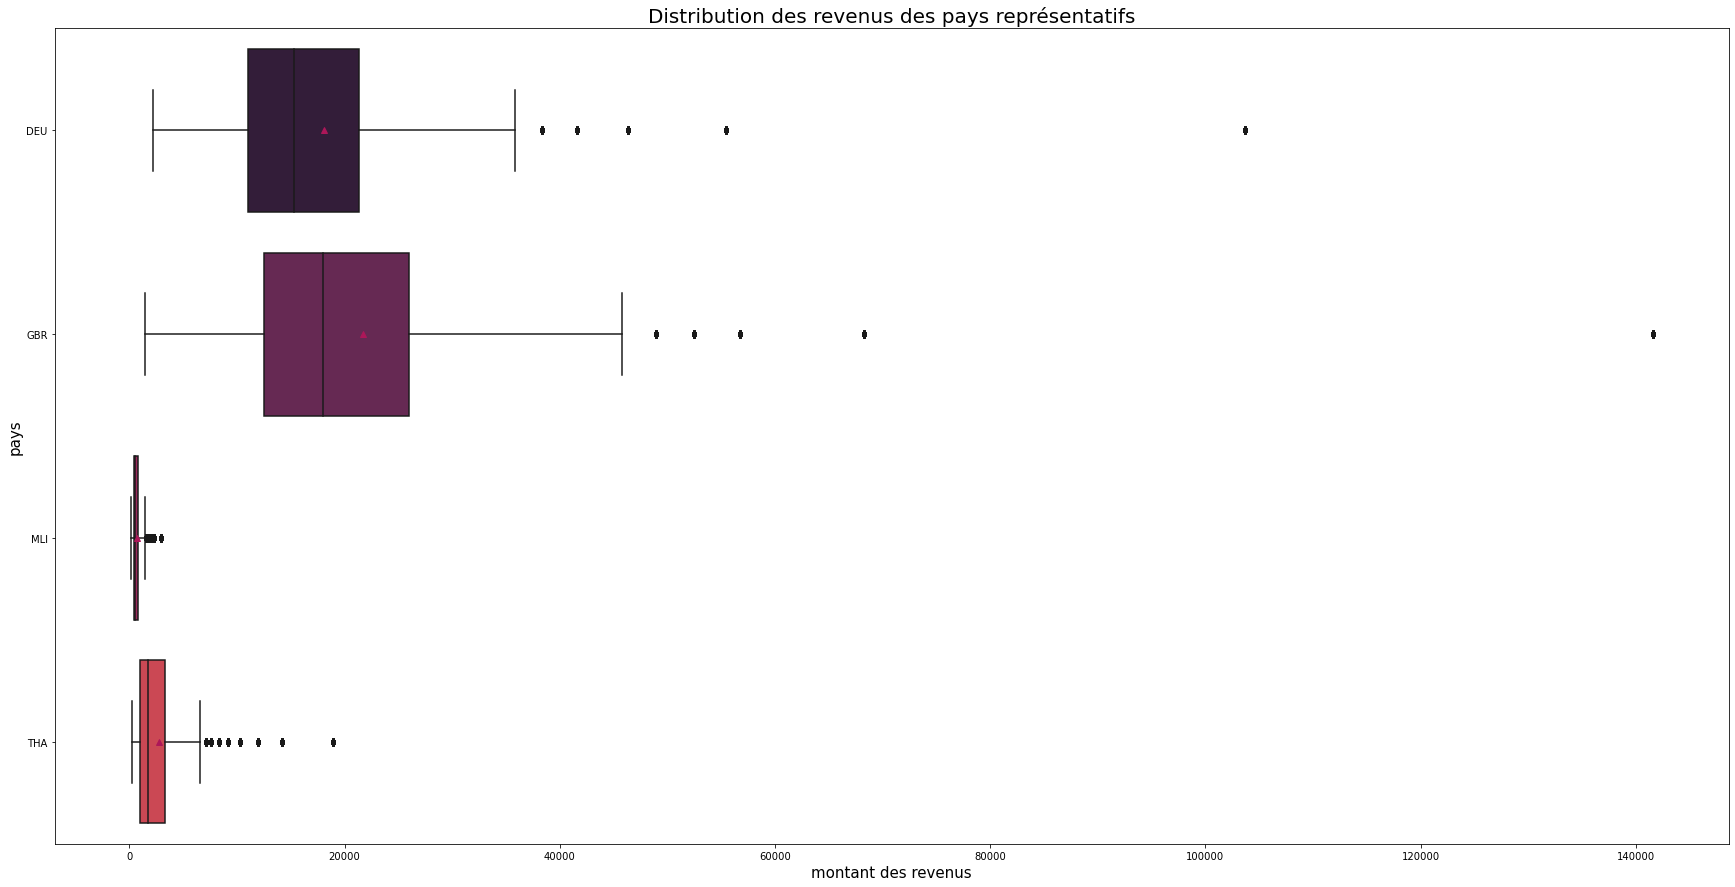

In [42]:
pays_rep = ['GBR','DEU','THA','MLI']
incomes_pays = bdd_p7[bdd_p7['country'].isin(pays_rep)]

plt.figure(figsize=(30,15))

sns.boxplot(
    data=incomes_pays, 
    x='income_child', y='country', showmeans=True)

plt.title("Distribution des revenus des pays représentatifs", size=20)
plt.ylabel("pays", size=15)
plt.xlabel("montant des revenus", size=15)

plt.savefig("/Users/anissa/05_Boxplots revenus (pays représentatifs).jpg", dpi=1200)
plt.show()

***Boxplots pour tous les pays***

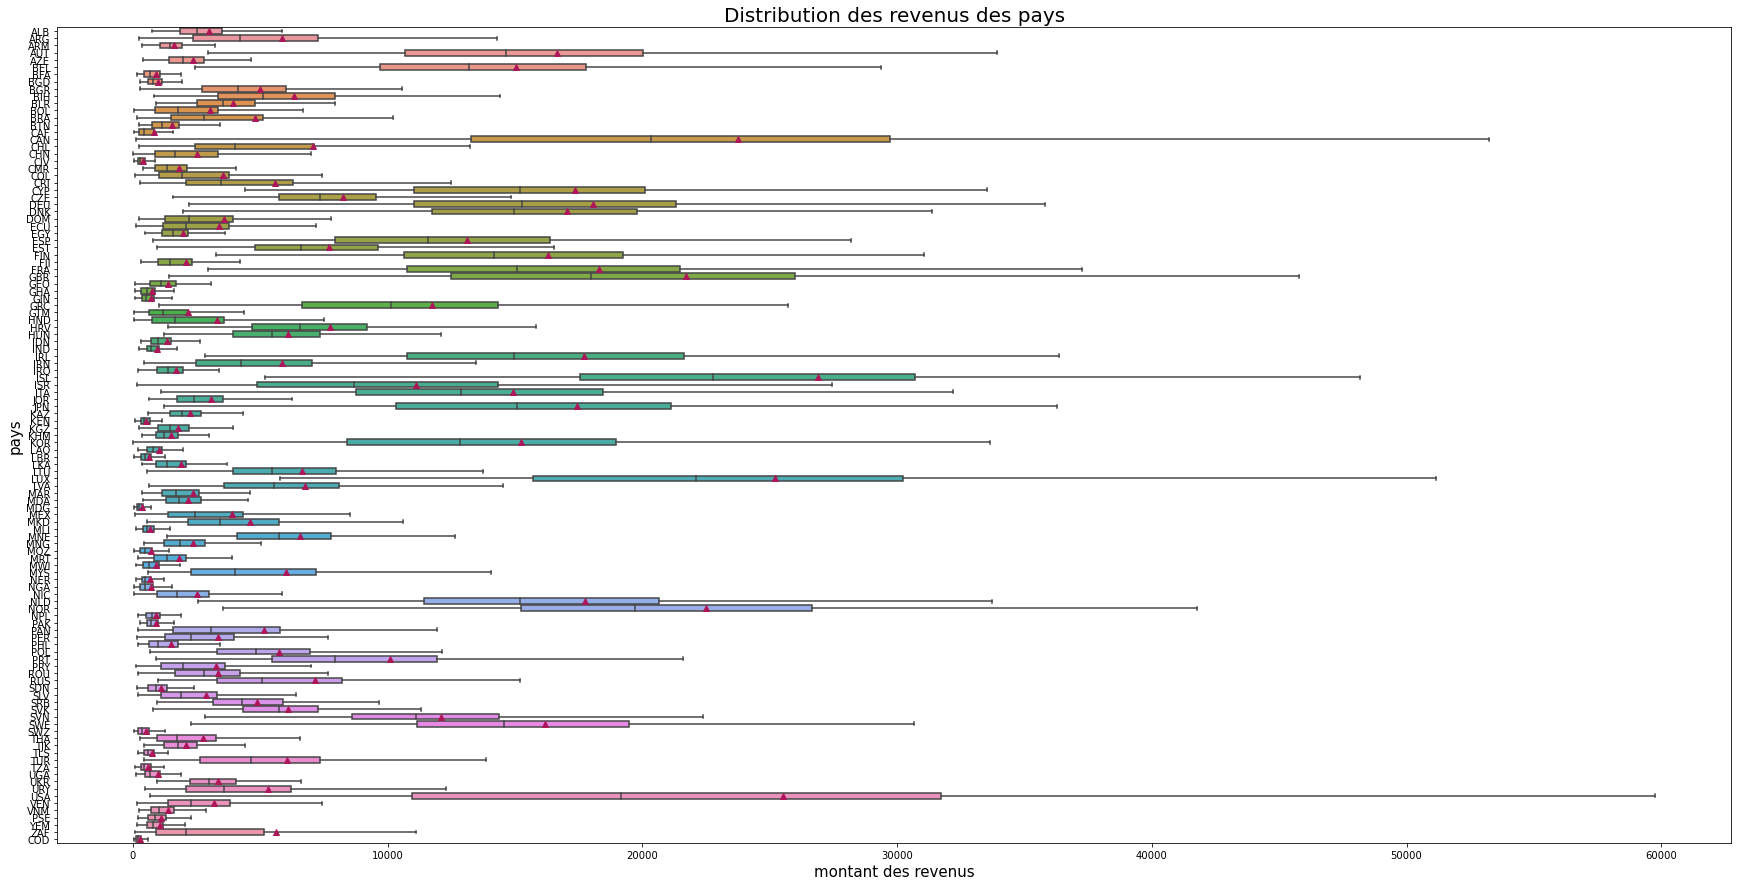

In [43]:
plt.figure(figsize=(30,15))

sns.boxplot(
    data=bdd_p7, 
    x='income_child', y='country', 
    showfliers=False, showmeans=True)

plt.title("Distribution des revenus des pays", size=20)
plt.ylabel("pays", size=15)
plt.xlabel("montant des revenus", size=15)

plt.savefig("/Users/anissa/06_Boxplots revenus.jpg", dpi=1200)
plt.show()

On observe que les revenus **diffèrent selon les pays**. Nous allons donc vérifier cette observation grâce à l'ANOVA.

#### 5.2. ANOVA : le revenu diffère-t-il en fonction des pays ?

In [44]:
alpha = 0.05

anova_pays = smf.ols('income~country', data=data2).fit(alpha=alpha)
anova_pays.summary().tables[0]

Dep. Variable:,income,R-squared:,0.478
Model:,OLS,Adj. R-squared:,0.477
Method:,Least Squares,F-statistic:,408.8
Date:,"Sun, 08 Aug 2021",Prob (F-statistic):,0.00
Time:,17:17:22,Log-Likelihood:,-5.1402e+05
No. Observations:,50100,AIC:,1.028e+06
Df Residuals:,49987,BIC:,1.029e+06
Df Model:,112,,
Covariance Type:,nonrobust,,


In [45]:
print("Coefficient de détermination:", anova_pays.rsquared)
print("Le pays d'origine explique environ", 100*round(anova_pays.rsquared, 3), '% de la variance de la variable "income"')

Coefficient de détermination: 0.47805097488754233
Le pays d'origine explique environ 47.8 % de la variance de la variable "income"


Nous posons donc les hypothèses suivantes :  
$H_0$ : Le pays d'origine n'a aucune influence sur le revenu de l'individu.  
$H_1$ : Le pays d'origine influence le revenu de l'individu.  

In [46]:
# Affichage du résultat de l'ANOVA
test = sm.stats.anova_lm(anova_pays, typ=1)
test

,df,sum_sq,mean_sq,F,PR(>F)
country,112.0,2.192111e+12,1.957242e+10,408.775791,0.0
Residual,49987.0,2.393406e+12,4.788058e+07,NaN,NaN


Au niveau de test 5%, nous rejetons l'hypothèse $H_0$. Selon ce test, le pays d'origine _influence_ donc les revenus.  
Cependant, nous devons vérifier certaines conditions afin de valider l'ANOVA : la **normalité des résidus** et l'**homogénéité des variances**.

#### 5.3. Vérification des conditions de validation de l'ANOVA

##### 5.3.1. Représentation graphique des résidus : droite de Henry

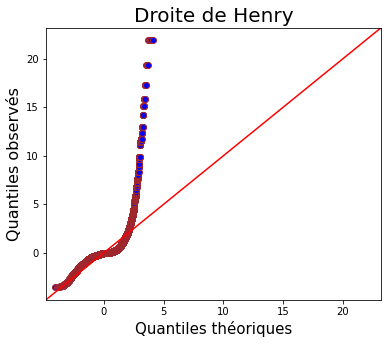

In [47]:
def residus_henry(MODEL, nom, couleur, ax):
    sm.qqplot(MODEL.resid, ax=ax, line="45", fit=True, color=couleur)
    ax.set_title("Droite de Henry", fontsize=20)
    ax.set_xlabel("Quantiles théoriques" ,fontsize=15), ax.set_ylabel("Quantiles observés", fontsize=16)
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
residus_henry(anova_pays, "ANOVA", "brown", ax) ; 

plt.show()

Remarque : on observe que les résidus ne suivraient pas une loi normale. On effectuera une test de Kolmogorov-Smirnov pour l'affirmer ou non.

##### 5.3.2. Test d'adéquation à la loi normale : Kolmogorov-Smirnov

In [48]:
def test_residus_KS(MODEL):
    MR=MODEL.resid
    KS=ks_2samp(MR,list(np.random.normal(MR.mean(), MR.std(), len(MR))))
    print("TEST DE KOLMOGOROV-SMIRNOV:", " statistic =", KS[0], " pvalue =", KS[1])

test_residus_KS(anova_pays) # ne suit pas une loi normale

TEST DE KOLMOGOROV-SMIRNOV:  statistic = 0.2431536926147705  pvalue = 0.0


##### 5.3.3. Vérification de l'homoscédasticité des résidus : Breusch-Pagan

In [49]:
def test_residus_BP(MODEL):
    BP=sm.stats.diagnostic.het_breuschpagan(MODEL.resid, MODEL.model.exog)
    print("TEST DE BREUSCH-PAGAN:", " statistic =", BP[0], " pvalue =", BP[1])
    
test_residus_BP(anova_pays) # hétérogénéité

TEST DE BREUSCH-PAGAN:  statistic = 1766.470301026393  pvalue = 2.3673043941505864e-295


Les conditions ne sont pas validées, nous devons procéder à une alternative de l'ANOVA pour vérifier si les revenus sont bien différents selon les pays. Un test de **Kruskal-Wallis** sera donc réalisé.

##### 5.3.4. Alternative à l'ANOVA : Kruskal-Wallis

In [50]:
pg.kruskal(data2, dv='income', between='country')

,Source,ddof1,H,p-unc
Kruskal,country,112,36709.606357,0.0


La p-value est encore inférieure à 5%, et valide l'ANOVA précédente : les revenus moyens **diffèrent** bien entre pays.

#### 5.4. Passage aux logarithmes

##### 5.4.1. Comparaison de la distribution de la variable "y_child" avant et après le passage aux logarithmes

<Figure size 1440x1440 with 0 Axes>

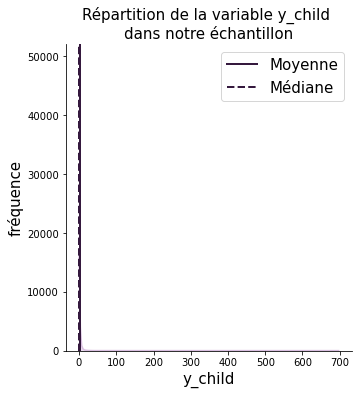

In [67]:
plt.figure(figsize = (20,20))

sns.displot(bdd_p7["y_child"],
                     kde=True,
                  color='#D9BFE0')

plt.axvline(x=bdd_p7["y_child"].mean(), label='Moyenne', linestyle='-', linewidth=2)
plt.axvline(x=bdd_p7["y_child"].median(), label='Médiane', linestyle='--', linewidth=2)
plt.xlabel('y_child', size=15)
plt.ylabel('fréquence', size=15)
plt.title('Répartition de la variable y_child \ndans notre échantillon', size=15)
plt.legend(prop={"size":15})

plt.savefig("/Users/anissa/07_Répartition de la variable y_child dans notre échantillon.jpg", dpi=1200)
plt.show()

<Figure size 1440x1440 with 0 Axes>

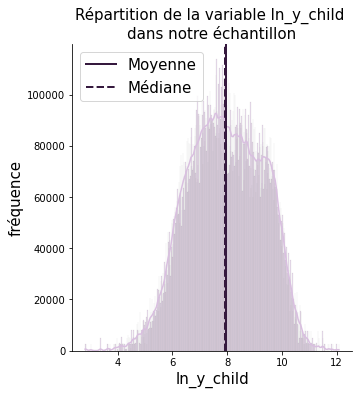

In [68]:
plt.figure(figsize = (20,20))

sns.displot(bdd_p7["ln_y_child"],
                     kde=True,
                  color='#D9BFE0')

plt.axvline(x=bdd_p7["ln_y_child"].mean(), label='Moyenne', linestyle='-', linewidth=2)
plt.axvline(x=bdd_p7["ln_y_child"].median(), label='Médiane', linestyle='--', linewidth=2)
plt.xlabel('ln_y_child', size=15)
plt.ylabel('fréquence', size=15)
plt.title('Répartition de la variable ln_y_child \ndans notre échantillon', size=15)
plt.legend(prop={'size':15})

plt.savefig("/Users/anissa/08_Répartition de la variable ln_y_child dans notre échantillon.jpg", dpi=1200)

plt.show()

Remarque : le passage aux logarithmes nous permet d'avoir un modèle plus robuste, améliore l'ajustement du modèle, d'avoir des résidus symétriques. La distribution est donc plus **proche d'une distribution gaussienne**.

#### 5.2. Regression linéaire : Revenu moyen du pays et indice de Gini

##### 5.2.1. Sans le passage aux logarithmes

Hypothèses :  
    On émet deux à deux les quatre hypothèses de test:  
$H0$: le paramètre de la variable n'est pas significatif.  
$H1$: le paramètre de la variable est significatif.  

In [53]:
RL1 = smf.ols("y_child ~ mj+Gj", data=bdd_p7).fit(alpha=alpha)  ;  RL1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                y_child   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     3806.
Date:                Sun, 08 Aug 2021   Prob (F-statistic):               0.00
Time:                        17:19:37   Log-Likelihood:            -5.6544e+06
No. Observations:             2100000   AIC:                         1.131e+07
Df Residuals:                 2099997   BIC:                         1.131e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.4776      0.013    115.507      0.000       1.452       1.503
mj         -1.398e-05   3.73e-07    -37.447      0.000   -1.47e-05   -1.32e-05
Gj             0.0167      0.000     57.353      0.000       0.016       0.017
==============================================================================
Omnibus:                  4669054.004   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     220791102184.372
Skew:                          19.847   Prob(JB):                         0.00
Kurtosis:                    1591.002   Cond. No.                     6.66e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.66e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Nous obtenons que les 2 pvalues sont de 0 pour chacune des deux variables, ce qui nous conduit à rejeter l'hypothèse $H0$ : Les deux variables mj et Gj sont alors significatives au niveau de test de 5%.

##### 5.2.2. Après le passage aux logarithmes

In [54]:
RL2 = smf.ols("ln_y_child ~ ln_mj+Gj", data=bdd_p7).fit(alpha=alpha)  ;  RL2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             ln_y_child   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.620
Method:                 Least Squares   F-statistic:                 1.283e+07
Date:                Sun, 08 Aug 2021   Prob (F-statistic):               0.00
Time:                        17:19:41   Log-Likelihood:            -1.7477e+07
No. Observations:            15700000   AIC:                         3.495e+07
Df Residuals:                15699997   BIC:                         3.495e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4133      0.002    174.244      0.000       0.409       0.418
ln_mj          0.9992      0.000   4413.896      0.000       0.999       1.000
Gj            -0.0183   2.17e-05   -843.627      0.000      -0.018      -0.018
==============================================================================
Omnibus:                  1363535.212   Durbin-Watson:                   0.088
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          7253649.461
Skew:                          -0.249   Prob(JB):                         0.00
Kurtosis:                       6.292   Cond. No.                         501.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Nous obtenons que les 2 pvalues sont de 0 pour chacune des deux variables, ce qui nous conduit à rejeter l'hypothèse $H0$ : Les deux variables mj et Gj sont alors significatives au niveau de test de 5%.

In [55]:
# Analyse de la première régression linéaire sans passer au logarithme:
print("COEFFICIENT DE DÉTERMINATION DE RL1 - SANS PASSER AU LOGARITHME:", round(RL1.rsquared, 4))
# Analyse de la seconde régression linéaire en passant au logarithme:
print("COEFFICIENT DE DÉTERMINATION DE RL2 - EN PASSANT AU LOGARITHME:", round(RL2.rsquared, 4))

COEFFICIENT DE DÉTERMINATION DE RL1 - SANS PASSER AU LOGARITHME: 0.0036
COEFFICIENT DE DÉTERMINATION DE RL2 - EN PASSANT AU LOGARITHME: 0.6205


##### 5.2.3. Représentation graphique : droite de Henry

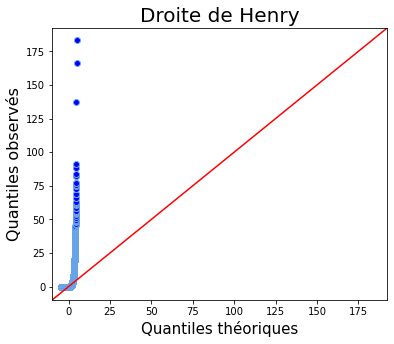

In [56]:
def analyse_des_residus(MODEL, nom, couleur):
    fig, (ax1) = plt.subplots(1, 1, figsize=(6, 5))
    residus_henry(MODEL, nom, couleur, ax1)
analyse_des_residus(RL1, "RL1", "#6CABE7") ; plt.show()

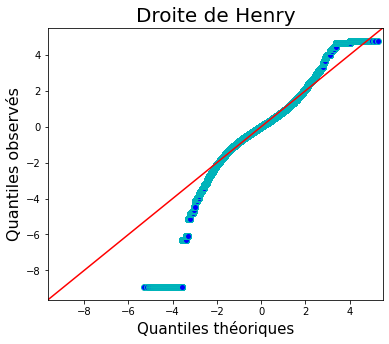

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
residus_henry(RL2, "RL2", "#00BAB9", ax) ; plt.show()

Remarque : on observe que les résidus du second modèle (passage aux logarithmes) suivent plus une loi normale que ceux du premier modèle. Le passage aux logarithmes permet donc d'avoir un modèle plus viable.

#### 5.3. Regression linéaire : revenu moyen, indice de Gini et classe de revenu des parents

In [58]:
RL3= smf.ols("ln_y_child ~ ln_mj+Gj+c_i_parent", data=bdd_p7).fit(alpha=alpha) ; RL3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             ln_y_child   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.620
Method:                 Least Squares   F-statistic:                 8.556e+06
Date:                Sun, 08 Aug 2021   Prob (F-statistic):               0.00
Time:                        17:20:04   Log-Likelihood:            -1.7477e+07
No. Observations:            15700000   AIC:                         3.495e+07
Df Residuals:                15699996   BIC:                         3.496e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4132      0.002    172.562      0.000       0.408       0.418
ln_mj          0.9992      0.000   4413.896      0.000       0.999       1.000
Gj            -0.0183   2.17e-05   -843.627      0.000      -0.018      -0.018
c_i_parent  2.544e-06   6.44e-06      0.395      0.693   -1.01e-05    1.52e-05
==============================================================================
Omnibus:                  1363534.949   Durbin-Watson:                   0.088
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          7253644.750
Skew:                          -0.249   Prob(JB):                         0.00
Kurtosis:                       6.292   Cond. No.                         876.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

La variance expliquée est la même que précédemment, qu'on ajoute c_i_parent ou non.

##### 5.3.1. Représentation graphique : droite de Henry

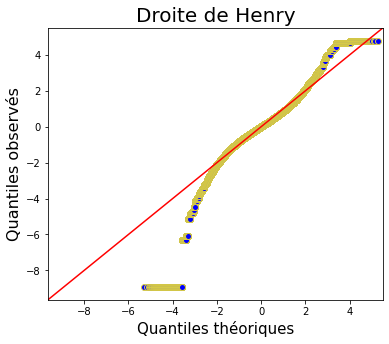

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
residus_henry(RL3, "RL3", "#D8CC46", ax) ; plt.show()

Remarque : le passage des variables aux logarithmes permettent d'avoir un modèle plus pertinent car la distribution se rapproche d'une distribution gaussienne, condition à valider pour accèder une regression linéaire.

#### 5.4. Regression linéaire : ajout des variables restantes

In [60]:
RL4=smf.ols("ln_y_child ~ ln_mj+Gj+c_i_parent+ln_y_parent+coeff_elasticite", data=bdd_p7).fit(alpha=alpha) ; RL4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             ln_y_child   R-squared:                       0.622
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                 6.904e+05
Date:                Sun, 08 Aug 2021   Prob (F-statistic):               0.00
Time:                        17:20:21   Log-Likelihood:            -2.2894e+06
No. Observations:             2100000   AIC:                         4.579e+06
Df Residuals:                 2099994   BIC:                         4.579e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.3266      0.008     39.740      0.000       0.311       0.343
ln_mj                1.0089      0.001   1454.857      0.000       1.008       1.010
Gj                  -0.0188   7.14e-05   -262.933      0.000      -0.019      -0.019
c_i_parent        8.747e-06   8.09e-05      0.108      0.914      -0.000       0.000
ln_y_parent        6.32e-05      0.002      0.027      0.978      -0.005       0.005
coeff_elasticite     0.0248      0.003      8.612      0.000       0.019       0.030
==============================================================================
Omnibus:                   251761.620   Durbin-Watson:                   0.423
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1700650.264
Skew:                          -0.376   Prob(JB):                         0.00
Kurtosis:                       7.344   Cond. No.                     1.13e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [61]:
print("Ce nouveau modèle explique environ", round(100*RL4.rsquared, 2), '% de la variance de la variable "ln_y_child"')

Ce nouveau modèle explique environ 62.18 % de la variance de la variable "ln_y_child"


##### 5.4.1. Représentation graphique : droite de Henry

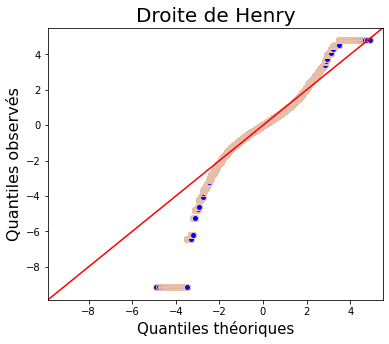

In [62]:
analyse_des_residus(RL4, "RL4", "#EEC5A9") ; plt.show()

Remarque : on observe là aussi une distribution proche d'une loi normale

________________

### 6. Conclusion

Pour accepter une regression linéaire, et ainsi observer des relations entre nos variables, les residus doivent suivre une loi normale. Le passage aux logarithmes nous a permis d'avoir des modèles fiables puisque ce passage permet de se rapprocher d'une distribution normale.  
A la suite de nos modèles, on peut donc conclure que le revenu d'un individu dépend du revenu moyen de son origine. Cela a été expliqué à hauteur de 62% par l'analyse de la variance. Le reste, à savoir 38%, est expliqué par des facteurs extérieurs non considérés par le modèle comme la chance et les efforts, par exemple. D'autres facteurs peuvent expliquer le revenu d'un individu et peuvent améliorer notre modèle (niveau d'études, sexe, classe sociale etc.).

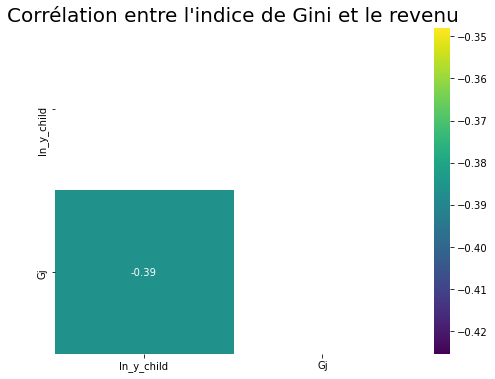

In [63]:
# Observation de corrélation entre le revenu et l'indice de Gini des pays
correlation_matrix = bdd_p7[['ln_y_child', 'Gj']].corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=np.bool))
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='viridis')

plt.title("Corrélation entre l'indice de Gini et le revenu", size=20)

plt.savefig("/Users/anissa/09_Corrélation entre l'indice de Gini et le revenu.jpg", dpi=1200)
plt.show()

On observe une corrélation négative entre les deux variables les plus explicatives : _plus l'indice de Gini est bas, plus le revenu moyen a tendance à être haut_.